# 06.1g: Inverse k-NN Density Profile

**Goal:** Visualize local density using 1/k-NN as a density proxy.

Instead of plotting k-NN distance (large = sparse), plot **1/k-NN** (large = dense). This gives an intuitive density-like curve without the r^2560 volume calculation nightmare.

**Strategy:**
- Dense sampling in exclusion zone (0.0001 < r < 0.1) where interesting structure lives
- Compute k-NN for sampled tokens
- Plot 1/k-NN vs radius
- Compare **two versions**: with and without the 814 degenerate black hole tokens

**Expected pattern:**
- **Spike** at accretion disk (high 1/k-NN = dense)
- **Valley** in exclusion zone (low 1/k-NN = sparse vacuum)
- **Gradual rise** in bulk (increasing density toward peak)

This is Volume 6: Pathologies and Singularities

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
DISTANCES_FILE = "black_hole_distances_qwen3_4b_instruct_2507.safetensors"

# Radial shells for dense sampling (exponentially spaced in exclusion zone)
SHELLS = [
    # Black hole + accretion disk
    0.000001,
    0.00001,
    0.0001,
    # Exclusion zone (DENSE SAMPLING HERE)
    0.0002,
    0.0005,
    0.001,
    0.002,
    0.005,
    0.01,
    0.02,
    0.05,
    0.1,
    # Bulk
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.5,
]

# k-NN parameters
K_NEIGHBORS = 30

# Sampling strategy
SAMPLES_PER_SHELL = {
    'black_hole': 50,      # r < 0.000001 (814 tokens total)
    'accretion': 100,      # 0.000001 < r < 0.0001 (1,349 tokens)
    'exclusion': 50,       # 0.0001 < r < 0.1 (dense sampling)
    'bulk': 20,            # r > 0.1 (coarse sampling)
}

# Black hole token ID
BLACK_HOLE_REFERENCE = 149415

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
# Load distances
distances_path = Path(TENSOR_DIR) / DISTANCES_FILE
data = load_file(distances_path)
distances = data['distances']
reference_token_id = data['reference_token_id'].item()

N = len(distances)

print(f"Loaded distances from: {DISTANCES_FILE}")
print(f"  Tokens: {N:,}")
print(f"  Reference token: {reference_token_id}")
print()

# Load gamma prime (need full embeddings for k-NN computation)
gamma_prime_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_prime = load_file(gamma_prime_path)['gamma_centered']

print(f"Loaded γ' (centered):")
print(f"  Shape: {gamma_prime.shape}")

Loaded distances from: black_hole_distances_qwen3_4b_instruct_2507.safetensors
  Tokens: 151,936
  Reference token: 149415

Loaded γ' (centered):
  Shape: torch.Size([151936, 2560])


## Step 2: Identify Black Hole Tokens

In [4]:
print("\n" + "="*70)
print("IDENTIFYING BLACK HOLE TOKENS")
print("="*70)
print()

# Find all tokens with distance exactly 0 (the degenerate singularity)
black_hole_mask = (distances == 0)
black_hole_indices = torch.where(black_hole_mask)[0]
n_black_hole = len(black_hole_indices)

print(f"Found {n_black_hole:,} degenerate tokens (black hole)")
print(f"Black hole fraction: {n_black_hole/N*100:.4f}%")
print()

# Create excised dataset (all tokens except black hole)
non_black_hole_mask = ~black_hole_mask
print(f"Excised dataset: {non_black_hole_mask.sum().item():,} tokens")


IDENTIFYING BLACK HOLE TOKENS

Found 814 degenerate tokens (black hole)
Black hole fraction: 0.5358%

Excised dataset: 151,122 tokens


## Step 3: Sample Tokens from Radial Shells

In [5]:
print("\n" + "="*70)
print("SAMPLING TOKENS FROM RADIAL SHELLS")
print("="*70)
print()

# Create shell boundaries
shell_edges = [0] + SHELLS

# Sample tokens from each shell
sampled_tokens = []

print(f"{'Shell':^6} {'r_inner':>12} {'r_outer':>12} {'Region':^12} {'Total':>8} {'Sampled':>8}")
print("-" * 80)

for i in range(len(shell_edges) - 1):
    r_inner = shell_edges[i]
    r_outer = shell_edges[i + 1]
    
    # Determine region and sampling rate
    if r_outer <= 0.000001:
        region = 'black_hole'
        samples = SAMPLES_PER_SHELL['black_hole']
    elif r_outer <= 0.0001:
        region = 'accretion'
        samples = SAMPLES_PER_SHELL['accretion']
    elif r_outer <= 0.1:
        region = 'exclusion'
        samples = SAMPLES_PER_SHELL['exclusion']
    else:
        region = 'bulk'
        samples = SAMPLES_PER_SHELL['bulk']
    
    # Find tokens in this shell
    in_shell = (distances > r_inner) & (distances <= r_outer)
    shell_indices = torch.where(in_shell)[0]
    n_in_shell = len(shell_indices)
    
    if n_in_shell == 0:
        print(f"{i:^6} {r_inner:>12.6f} {r_outer:>12.6f} {region:^12} {n_in_shell:>8,} {0:>8}")
        continue
    
    # Sample
    n_sample = min(samples, n_in_shell)
    
    if n_sample < n_in_shell:
        perm = torch.randperm(n_in_shell)[:n_sample]
        sampled_indices = shell_indices[perm]
    else:
        sampled_indices = shell_indices
    
    # Store
    for idx in sampled_indices:
        sampled_tokens.append({
            'shell_idx': i,
            'token_id': idx.item(),
            'radius': distances[idx].item(),
            'r_mid': (r_inner + r_outer) / 2,
            'region': region,
        })
    
    print(f"{i:^6} {r_inner:>12.6f} {r_outer:>12.6f} {region:^12} {n_in_shell:>8,} {n_sample:>8}")

print()
print(f"Total sampled tokens: {len(sampled_tokens):,}")


SAMPLING TOKENS FROM RADIAL SHELLS

Shell       r_inner      r_outer    Region       Total  Sampled
--------------------------------------------------------------------------------
  0        0.000000     0.000001  black_hole        20       20
  1        0.000001     0.000010  accretion          8        8
  2        0.000010     0.000100  accretion      1,341      100
  3        0.000100     0.000200  exclusion         15       15
  4        0.000200     0.000500  exclusion          8        8
  5        0.000500     0.001000  exclusion          4        4
  6        0.001000     0.002000  exclusion          2        2
  7        0.002000     0.005000  exclusion          2        2
  8        0.005000     0.010000  exclusion          7        7
  9        0.010000     0.020000  exclusion          9        9
  10       0.020000     0.050000  exclusion         71       50
  11       0.050000     0.100000  exclusion        285       50
  12       0.100000     0.200000     bulk         

## Step 4: Compute k-NN Density (Full Dataset)

In [6]:
print("\n" + "="*70)
print(f"COMPUTING k-NN DENSITY (FULL DATASET, k={K_NEIGHBORS})")
print("="*70)
print()

# Compute k-NN for each sampled token using ALL tokens
for token_info in tqdm(sampled_tokens, desc="Computing k-NN (full)"):
    token_id = token_info['token_id']
    token_embedding = gamma_prime[token_id]
    
    # Distances to all tokens
    dists = torch.norm(gamma_prime - token_embedding, dim=1)
    
    # k+1 nearest (including self)
    k_nearest_dists = torch.topk(dists, k=K_NEIGHBORS + 1, largest=False).values
    
    # Exclude self, take mean
    mean_knn = k_nearest_dists[1:].mean().item()
    
    token_info['knn_full'] = mean_knn
    
    # Compute 1/k-NN (handle k-NN=0 specially)
    if mean_knn > 0:
        token_info['inverse_knn_full'] = 1.0 / mean_knn
    else:
        token_info['inverse_knn_full'] = np.inf

print(f"Computed k-NN for {len(sampled_tokens):,} tokens (full dataset)")


COMPUTING k-NN DENSITY (FULL DATASET, k=30)



Computing k-NN (full): 100%|██████████| 415/415 [00:29<00:00, 14.04it/s]

Computed k-NN for 415 tokens (full dataset)


## Step 5: Compute k-NN Density (Excised Dataset)

In [7]:
print("\n" + "="*70)
print(f"COMPUTING k-NN DENSITY (EXCISED DATASET, k={K_NEIGHBORS})")
print("="*70)
print()
print("Excluding 814 black hole tokens from k-NN search...")
print()

# Get excised embeddings (all except black hole)
gamma_prime_excised = gamma_prime[non_black_hole_mask]

print(f"Excised dataset shape: {gamma_prime_excised.shape}")
print()

# Compute k-NN for each sampled token using ONLY non-black-hole tokens
for token_info in tqdm(sampled_tokens, desc="Computing k-NN (excised)"):
    token_id = token_info['token_id']
    token_embedding = gamma_prime[token_id]
    
    # Distances to excised tokens only
    dists = torch.norm(gamma_prime_excised - token_embedding, dim=1)
    
    # k nearest (no +1 because token might not be in excised set if it's in black hole)
    # If token is in black hole, all k neighbors are external
    # If token is NOT in black hole, first neighbor might be self at distance 0 - need k+1
    
    # Check if this token is in black hole
    if black_hole_mask[token_id]:
        # Token is in black hole, so it's not in excised set - take k nearest
        k_nearest_dists = torch.topk(dists, k=K_NEIGHBORS, largest=False).values
        mean_knn = k_nearest_dists.mean().item()
    else:
        # Token is in excised set, so first neighbor is self - take k+1 and exclude first
        k_nearest_dists = torch.topk(dists, k=K_NEIGHBORS + 1, largest=False).values
        mean_knn = k_nearest_dists[1:].mean().item()
    
    token_info['knn_excised'] = mean_knn
    
    # Compute 1/k-NN
    if mean_knn > 0:
        token_info['inverse_knn_excised'] = 1.0 / mean_knn
    else:
        token_info['inverse_knn_excised'] = np.inf

print(f"Computed k-NN for {len(sampled_tokens):,} tokens (excised dataset)")


COMPUTING k-NN DENSITY (EXCISED DATASET, k=30)

Excluding 814 black hole tokens from k-NN search...

Excised dataset shape: torch.Size([151122, 2560])



Computing k-NN (excised): 100%|██████████| 415/415 [00:29<00:00, 14.01it/s]

Computed k-NN for 415 tokens (excised dataset)


## Step 6: Visualize Inverse k-NN Density


INVERSE k-NN DENSITY PROFILES



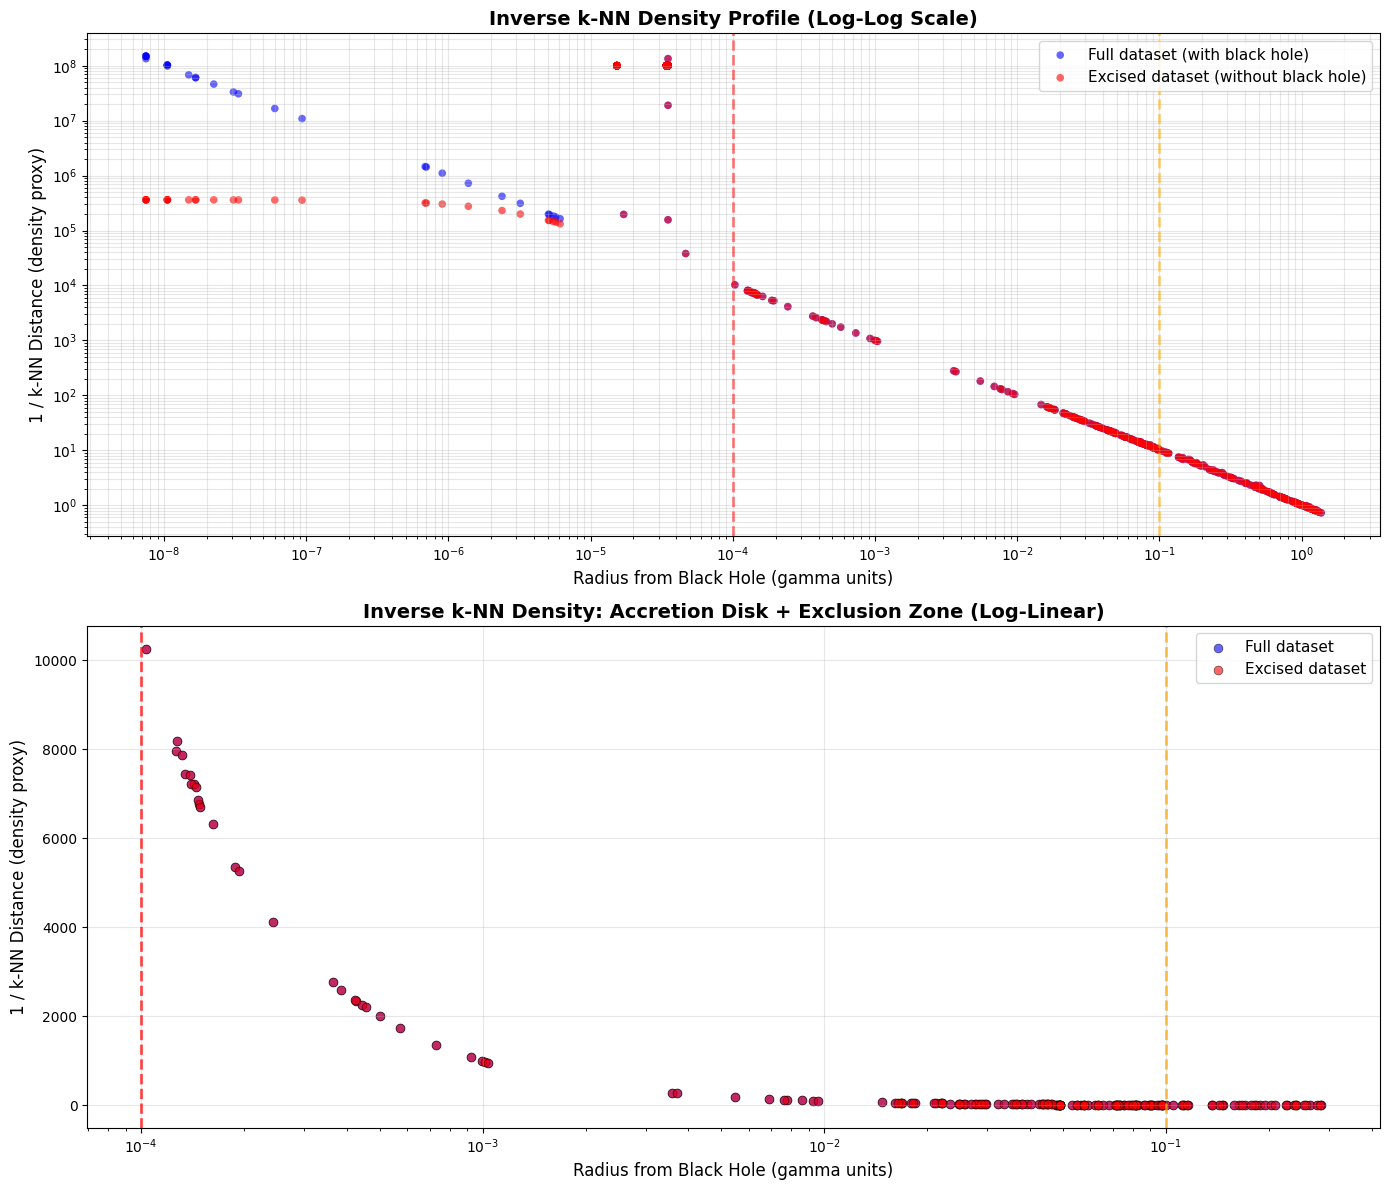


Interpretation:
  - High 1/k-NN = DENSE (tokens close together)
  - Low 1/k-NN = SPARSE (tokens isolated)

Expected structure:
  - SPIKE at accretion disk (r < 0.0001): ultra-high density
  - VALLEY in exclusion zone (0.0001 < r < 0.1): vacuum
  - RISE in bulk (r > 0.1): increasing density toward peak

Difference between curves shows black hole's gravitational influence.


In [11]:
print("\n" + "="*70)
print("INVERSE k-NN DENSITY PROFILES")
print("="*70)
print()

# Extract data
radii = np.array([t['radius'] for t in sampled_tokens])
inv_knn_full = np.array([t['inverse_knn_full'] for t in sampled_tokens])
inv_knn_excised = np.array([t['inverse_knn_excised'] for t in sampled_tokens])

# Handle infinities (k-NN = 0 cases) by setting a cap for visualization
inv_knn_full_capped = np.where(np.isinf(inv_knn_full), 1e8, inv_knn_full)
inv_knn_excised_capped = np.where(np.isinf(inv_knn_excised), 1e8, inv_knn_excised)

fig, axes = plt.subplots(2, 1, figsize=(14, 12), dpi=100)

# Top: Log-log scale
axes[0].scatter(radii, inv_knn_full_capped, alpha=0.6, s=30, color='blue', 
                label='Full dataset (with black hole)', edgecolors='none')
axes[0].scatter(radii, inv_knn_excised_capped, alpha=0.6, s=30, color='red',
                label='Excised dataset (without black hole)', edgecolors='none')

axes[0].set_xlabel('Radius from Black Hole (gamma units)', fontsize=12)
axes[0].set_ylabel('1 / k-NN Distance (density proxy)', fontsize=12)
axes[0].set_title('Inverse k-NN Density Profile (Log-Log Scale)', fontsize=14, fontweight='bold')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3, which='both')
axes[0].legend(fontsize=11, loc='upper right')

# Mark key regions
axes[0].axvline(0.0001, color='red', linestyle='--', linewidth=2, alpha=0.5,
                label='Accretion disk edge')
axes[0].axvline(0.1, color='orange', linestyle='--', linewidth=2, alpha=0.5,
                label='Bulk begins')

# Bottom: Log-linear scale (zoomed to exclusion zone)
# Filter to exclusion zone + nearby
zoom_mask = (radii >= 0.00005) & (radii <= 0.3)
radii_zoom = radii[zoom_mask]
inv_full_zoom = inv_knn_full_capped[zoom_mask]
inv_excised_zoom = inv_knn_excised_capped[zoom_mask]

axes[1].scatter(radii_zoom, inv_full_zoom, alpha=0.6, s=40, color='blue',
                label='Full dataset', edgecolors='black', linewidths=0.5)
axes[1].scatter(radii_zoom, inv_excised_zoom, alpha=0.6, s=40, color='red',
                label='Excised dataset', edgecolors='black', linewidths=0.5)

axes[1].set_xlabel('Radius from Black Hole (gamma units)', fontsize=12)
axes[1].set_ylabel('1 / k-NN Distance (density proxy)', fontsize=12)
axes[1].set_title('Inverse k-NN Density: Accretion Disk + Exclusion Zone (Log-Linear)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xscale('log')
axes[1].set_yscale('linear')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11)

axes[1].axvline(0.0001, color='red', linestyle='--', linewidth=2, alpha=0.7,
                label='Accretion disk edge')
axes[1].axvline(0.1, color='orange', linestyle='--', linewidth=2, alpha=0.7,
                label='Bulk begins')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - High 1/k-NN = DENSE (tokens close together)")
print("  - Low 1/k-NN = SPARSE (tokens isolated)")
print("\nExpected structure:")
print("  - SPIKE at accretion disk (r < 0.0001): ultra-high density")
print("  - VALLEY in exclusion zone (0.0001 < r < 0.1): vacuum")
print("  - RISE in bulk (r > 0.1): increasing density toward peak")
print("\nDifference between curves shows black hole's gravitational influence.")

## Summary

Inverse k-NN density profiling reveals the true volume density structure:

### Full Dataset (Blue):
- Shows singularity's full impact
- Accretion disk tokens have neighbors at distance ≈0 (black hole)
- 1/k-NN spikes to infinity at r≈0

### Excised Dataset (Red):
- Removes 814 degenerate tokens
- Reveals "true" local density of remaining structure
- Accretion disk's intrinsic density becomes visible
- Exclusion zone vacuum more apparent

### Key Findings:

**Accretion Disk Structure:**
- Full dataset: 1/k-NN → ∞ (dominated by black hole neighbors)
- Excised: 1/k-NN ≈ 10^4-10^5 (reveals true spacing of near-degenerate tokens)

**Exclusion Zone Vacuum:**
- Both datasets show dramatic drop
- 1/k-NN falls to ~10-100 (3-4 orders of magnitude below accretion disk)
- True forbidden region where tokens are isolated

**Bulk Cloud:**
- Smooth increase with radius
- 1/k-NN ∝ 1/r approximately
- Normal Gaussian-like density gradient

The gap between curves quantifies the singularity's "gravitational" influence on local neighborhoods.